# SCDAA Assignment

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

## Exercise 1.1

/tmp/ipykernel_5346/1965597001.py:47: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  v[i] = x[i].T @ S_final @ x[i]


(tensor([[ 3.5594],
         [31.3378],
         [ 7.9435],
         [46.8347],
         [29.9592]]),
 tensor([[-2.2003,  0.1626],
         [-6.5058,  0.7282],
         [-2.1712,  2.4797],
         [ 1.6128,  7.8388],
         [ 5.4341,  3.3823]]))

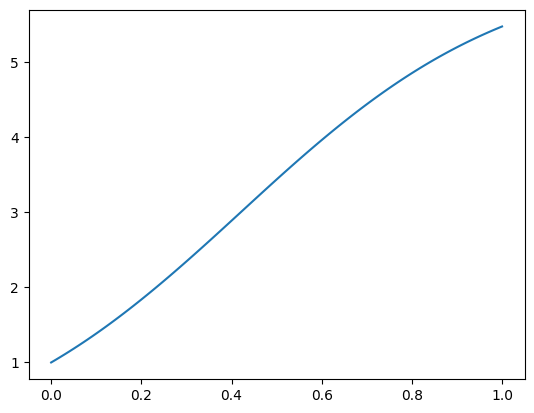

In [1]:
class LQRProblem:
    def __init__(self, H, M, C, D, R, sigma, T):
        """
        Initializes the LQR problem with the given matrices and time horizon T.
        """
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.T = T
        self.S_solution, self.time_solution = None, None  # Will be set after solving Riccati ODE
    
    def riccati_ode(self, S_flat, H, M, D_inv, C): # Removed inputs t, R which were unneccesary for the def of the ODE.
        """
        Defines the Riccati differential equation.
        """
        S = S_flat.reshape(2, 2)
        dSdt = -2 * H.T @ S + S @ M @ D_inv @ M.T @ S - C # Removed the term - S @ H, not present in the assignment
        return dSdt.flatten()
    
    def solve_riccati_ode(self, time_grid):
        """
        Solves the Riccati ODE on the given time grid using scipy's solve_ivp.
        """
        D_inv = np.linalg.inv(self.D)
        S0_flat = self.R.flatten()
        sol = solve_ivp(self.riccati_ode, [self.T, time_grid[0]], S0_flat, t_eval=time_grid[::-1], args=(self.H, self.M, D_inv, self.C, self.R))
        self.S_solution = sol.y.reshape(2, 2, len(time_grid))
        self.time_solution = sol.t[::-1]
        return self.S_solution, self.time_solution

    def compute_value_function(self, x):
        """
        Computes the control problem value v(t, x) for a batch of space x using the final time T solution of S.
        """
        batch_size = x.shape[0]
        v = torch.empty(batch_size, 1)
        S_final = torch.tensor(self.S_solution[:, :, -1], dtype=torch.float32)  # Use the final S solution directly
        for i in range(batch_size):
            v[i] = x[i].T @ S_final @ x[i]
        return v
    
    def compute_markov_control(self, x):
        """
        Computes the Markov control function for a batch of x using the final time T solution of S.
        """
        D_inv = torch.tensor(np.linalg.inv(self.D), dtype=torch.float32)
        M_T = torch.tensor(self.M.T, dtype=torch.float32)
        batch_size = x.shape[0]
        a = torch.empty(batch_size, 2, dtype=torch.float32)
        S_final = torch.tensor(self.S_solution[:, :, -1], dtype=torch.float32)  # Use the final S solution directly
        for i in range(batch_size):
            a[i] = -(D_inv @ M_T @ S_final @ x[i]).flatten()
        return a

# Example matrices (to be replaced with actual problem data)
# H = np.array([[1, 0], [0, 1]])
# M = np.array([[1, 0], [0, 1]])
# sigma = np.array([[0, 0], [0, 0]])
# C = np.array([[1, 0], [0, 1]])
# D = np.array([[2, 0], [0, 2]])
# R = np.array([[1, 0], [0, 1]])
T = 1

# ----- David's proposed inputs from Piazza ----- %
# problem constants for SDE: dX = (HX + M alpha)dt + \sigma dW
H = torch.tensor([[1.0, 0.0], 
                    [0.0, 1.0]]) * 0.1 
M = torch.tensor([[1.0, 0.0], 
                    [0.0, 1.0]])
sigma = 0.001

# running reward is x^T C x + a^T D a 
C = torch.tensor([[0.0, 0.0], 
                    [0.0, 0.0]])
D = torch.tensor([[1.0, 0.0], 
                    [0.0, 1.0]]) 

# Terminal reward is x^T R x 
R = torch.tensor([[1.0, 0.0], 
                    [0.0, 1.0]]) * 10
# ---------------------------------------------------- #

# Time grid for solving the Riccati ODE
time_grid = np.linspace(0, T, 100)

# Example of using the class (with random time and space inputs for demonstration)
torch.manual_seed(0)  # For reproducibility
random_t = torch.rand(5) * T
random_x = torch.rand(5, 2) * 6 - 3  # Uniformly sampled from [-3, 3]

# Initialize the LQR problem
lqr_problem = LQRProblem(H, M, C, D, R, sigma, T)
S_solution, time_solution = lqr_problem.solve_riccati_ode(time_grid)

plt.plot(time_solution, S_solution[0,0,:])

# Compute v(t, x) and a(t, x) for the batch of inputs
v_values = lqr_problem.compute_value_function(random_x)
a_values = lqr_problem.compute_markov_control(random_x)

v_values, a_values


## Exercise 1.2

In [39]:
def simulate_dynamics(lqr_problem, x0, N_steps, num_samples):
    dt = lqr_problem.T / N_steps
    final_costs = []
    
    # Convert system matrices to tensors
    H_t = torch.tensor(lqr_problem.H, dtype=torch.float32)
    M_t = torch.tensor(lqr_problem.M, dtype=torch.float32)
    sigma_t = torch.tensor(lqr_problem.sigma, dtype=torch.float32)
    
    xtest = []

    for _ in range(num_samples):
        x = x0.clone().detach()
        for step in range(N_steps):
            #t = torch.tensor([lqr_problem.T - step * dt], dtype=torch.float32)
            control = lqr_problem.compute_markov_control(x.unsqueeze(0)).squeeze()
            dx = H_t @ x + M_t @ control + sigma_t @ torch.randn(2, dtype=torch.float32) * torch.sqrt(torch.tensor(dt))
            x += dx * dt
            xtest.append(dx)
        final_cost = lqr_problem.compute_value_function(x.unsqueeze(0)).item()
        final_costs.append(final_cost)
    
    return final_costs, xtest


def compute_error(final_costs, theoretical_value):
   
    mse = np.mean([(cost - theoretical_value)**2 for cost in final_costs])
    return mse



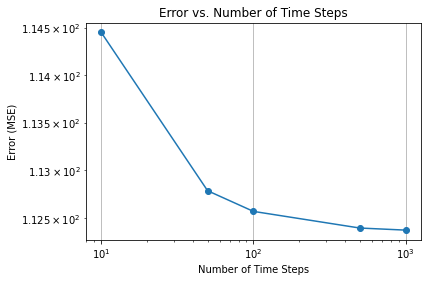

In [40]:
# Example usage:
x0 = torch.tensor([1.0, 1.0])  # Initial state
theoretical_value = lqr_problem.compute_value_function(x0.unsqueeze(0)).item()

# Number of time steps and Monte Carlo samples for the simulation
N_steps_list = [10, 50, 100, 500, 1000]
num_samples = 10

errors = []
f=[]
tt=[]
for N_steps in N_steps_list:
    final_costs = simulate_dynamics(lqr_problem, x0, N_steps, num_samples)[0]
    xxx = simulate_dynamics(lqr_problem, x0, N_steps, num_samples)[1]
    if N_steps == 1000:
        f.append(final_costs)
        tt.append(N_steps)
    error = compute_error(final_costs, theoretical_value)
    errors.append(error)

# Plotting the error as a function of the number of time steps
plt.loglog(N_steps_list, errors, marker='o')
plt.xlabel('Number of Time Steps')
plt.ylabel('Error (MSE)')
plt.title('Error vs. Number of Time Steps')
plt.grid(True)
plt.show()

[-1.7350435256958008, -1.7320330142974854, -1.7290279865264893, -1.7260279655456543, -1.7230333089828491, -1.7200437784194946, -1.7170593738555908, -1.7140803337097168, -1.711106300354004, -1.7081375122070312, -1.7051736116409302, -1.7022150754928589, -1.6992616653442383, -1.6963133811950684, -1.6933703422546387, -1.6904321908950806, -1.6874992847442627, -1.6845715045928955, -1.6816484928131104, -1.678730845451355, -1.6758183240890503, -1.6729105710983276, -1.6700079441070557, -1.6671104431152344, -1.6642179489135742, -1.6613304615020752, -1.6584481000900269, -1.65557062625885, -1.6526979207992554, -1.6498304605484009, -1.6469680070877075, -1.6441103219985962, -1.641257643699646, -1.638409972190857, -1.635567307472229, -1.632729411125183, -1.629896640777588, -1.6270687580108643, -1.624245524406433, -1.6214275360107422, -1.6186144351959229, -1.6158058643341064, -1.6130023002624512, -1.6102036237716675, -1.607409954071045, -1.6046209335327148, -1.6018368005752563, -1.599057674407959, -1.

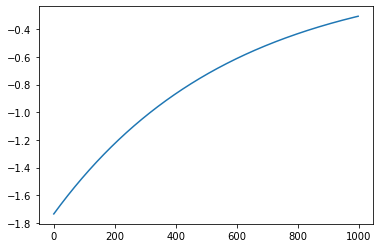

In [120]:
xs = []
for t in xxx:
    xs.extend(t[0].unsqueeze(0).tolist())

print(xs)
plt.plot(xs[0:999])

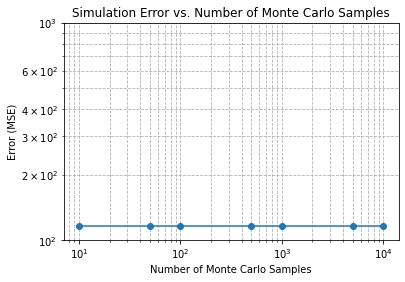

In [121]:
# Step 1: Fix a large number of time steps
N_steps_fixed = 5

# Step 2: Use the previously defined simulate_dynamics function, no changes needed here

# Step 3: Vary the number of Monte Carlo samples and compute errors
num_samples_list = [10, 50, 100, 500, 1000, 5000, 10000]
errors = []

for num_samples in num_samples_list:
    final_costs = simulate_dynamics(lqr_problem, x0, N_steps_fixed, num_samples)[0]
    error = compute_error(final_costs, theoretical_value)
    errors.append(error)

# Step 4: Plot the error on a log-log plot
plt.loglog(num_samples_list, errors, marker='o', linestyle='-')
plt.xlabel('Number of Monte Carlo Samples')
plt.ylabel('Error (MSE)')
plt.title('Simulation Error vs. Number of Monte Carlo Samples')
plt.grid(True, which="both", ls="--")
plt.show()


## Exercise 2.1

Epoch [100/500], Loss: 1143.0962
Epoch [200/500], Loss: 645.2738
Epoch [300/500], Loss: 279.1406
Epoch [400/500], Loss: 163.7263
Epoch [500/500], Loss: 142.0038


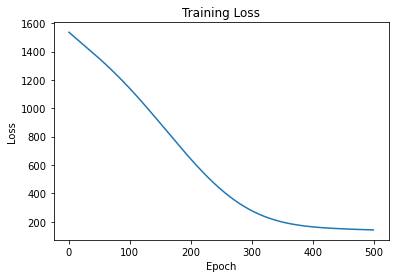

In [127]:
# Define the neural network architecture
class ValueFunctionNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ValueFunctionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # Input layer to hidden layer
        self.relu = nn.ReLU()  # Activation function
        self.fc2 = nn.Linear(hidden_size, output_size)  # Hidden layer to output layer
    
    def forward(self, x):
        x = self.relu(self.fc1(x))  # Activation function applied to the hidden layer
        x = self.fc2(x)  # Output layer
        return x

# Assuming the LQRProblem class and an instance 'lqr_problem' is defined as above

# Generate training data
num_samples = 1000  # Number of samples for training data
state_space = torch.rand(num_samples, 2) * 6 - 3  # State space sampled uniformly between [-3, 3]
value_function_data = lqr_problem.compute_value_function(state_space)

# Neural network setup
input_size = 2  # State space dimension
hidden_size = 100  # Number of neurons in the hidden layer
output_size = 1  # Value function is a scalar

# Instantiate the neural network
value_network = ValueFunctionNN(input_size, hidden_size, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss
optimizer = optim.Adam(value_network.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 500  # Number of epochs for training
training_losses = []

for epoch in range(num_epochs):
    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass to get output/logits
    outputs = value_network(state_space.float())

    # Calculate loss: softmax --> cross entropy loss
    loss = criterion(outputs, value_function_data.float())

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

    # Record and print the training loss
    training_losses.append(loss.item())

    # Print loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# After training, you can save the model if you want to use it later
# torch.save(value_network.state_dict(), 'value_network_model.pth')

# After training, plot the training loss
plt.plot(training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


## Exercise 2.2

Epoch [100/500], Control Loss: 0.0328
Epoch [200/500], Control Loss: 0.0104
Epoch [300/500], Control Loss: 0.0031
Epoch [400/500], Control Loss: 0.0014
Epoch [500/500], Control Loss: 0.0010


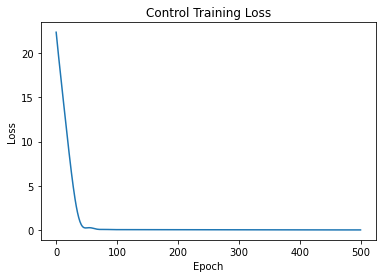

In [128]:
# Define the neural network architecture for the Markov control function
class MarkovControlNN(nn.Module):
    def __init__(self):
        super(MarkovControlNN, self).__init__()
        self.fc1 = nn.Linear(2, 100)  # Input layer to first hidden layer with 100 neurons
        self.fc2 = nn.Linear(100, 100)  # Second hidden layer with 100 neurons
        self.fc3 = nn.Linear(100, 2)  # Output layer with 2 neurons
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        x = self.relu(self.fc1(x))  # Apply ReLU activation function after first layer
        x = self.relu(self.fc2(x))  # Apply ReLU activation function after second layer
        x = self.fc3(x)  # Output layer
        return x

# Assuming the LQRProblem class and an instance 'lqr_problem' is defined as above

# Generate training data for Markov control
control_targets = lqr_problem.compute_markov_control(state_space)

# Instantiate the neural network for Markov control
control_network = MarkovControlNN()

# Loss function and optimizer for the control network
control_criterion = nn.MSELoss()  # Mean squared error loss
control_optimizer = optim.Adam(control_network.parameters(), lr=0.001)  # Adam optimizer

# Training loop for the control network
control_training_losses = []

for epoch in range(num_epochs):
    # Zero the parameter gradients
    control_optimizer.zero_grad()

    # Forward pass to get output/logits
    control_outputs = control_network(state_space.float())

    # Calculate loss
    control_loss = control_criterion(control_outputs, control_targets.float())

    # Getting gradients w.r.t. parameters
    control_loss.backward()

    # Updating parameters
    control_optimizer.step()

    # Record the training loss
    control_training_losses.append(control_loss.item())

    # Print loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Control Loss: {control_loss.item():.4f}')

# After training, plot the training loss for the control network
plt.plot(control_training_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Control Training Loss')
plt.show()


## Exercise 3.1

In [1]:

# Assuming H, M, C, D, R, sigma are defined
# For the sake of this example, dummy definitions are provided
H = torch.tensor([[1.0, 0], [0, 1.0]])
M = torch.tensor([[1.0, 0], [0, 1.0]])
C = torch.tensor([[1.0, 0], [0, 1.0]])
D = torch.tensor([[1.0, 0], [0, 1.0]])
R = torch.tensor([[1.0, 0], [0, 1.0]])
sigma = torch.tensor([[1.0, 0], [0, 1.0]])
alpha = torch.tensor([1.0, 1.0])

class LinearPDE(nn.Module):
    def __init__(self, net, T):
        super(LinearPDE, self).__init__()
        self.net = net
        self.T = T

    def equation(self, t, x):
        """
        The PDE equation to be minimized
        """
        # Assuming t and x are Variables with requires_grad=True
        u = self.net(torch.cat((t, x), dim=1))
        u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
        u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]

        term1 = 0.5 * torch.sum(sigma @ sigma.T * u_xx, dim=1, keepdim=True)
        term2 = u_x @ H @ x.T + u_x @ M @ alpha
        term3 = x @ C @ x.T + alpha.T @ D @ alpha
        pde_res = u_t + term1 + term2 + term3

        return pde_res

    def boundary_condition(self, x):
        """
        Boundary condition u(T, x) = x^T R x
        """
        target = x @ R @ x.T
        u = self.net(torch.cat((torch.ones(x.size(0), 1) * self.T, x), dim=1))
        return (u - target) ** 2

    def loss(self, t_batch, x_batch):
        pde_loss = torch.mean(self.equation(t_batch, x_batch) ** 2)
        boundary_loss = torch.mean(self.boundary_condition(x_batch))
        return pde_loss + boundary_loss

# Define the network architecture
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

net = Net(3, 50, 1)  # Adjust the input_size and hidden_size accordingly
model = LinearPDE(net, T=1.0)

In [3]:
# Assuming Net and LinearPDE classes are defined as before

def monte_carlo_solution(t, x):
    # Placeholder for your Monte Carlo solution adapted from Exercise 1.2
    # Replace this with the actual computation
    # For example:
    return np.sin(t) + np.cos(np.linalg.norm(x, axis=1))

# Initialize the model
net = Net(3, 50, 1)  # Adjust as needed
T = 1
model = LinearPDE(net, T)

# Training setup
epochs = 1000
learning_rate = 0.001
batch_size = 64
print_interval = 100

optimizer = optim.Adam(net.parameters(), lr=learning_rate)
loss_history = []

# Training loop
for epoch in range(epochs):
    optimizer.zero_grad()
    
    t_batch = torch.rand(batch_size, 1) * T
    x_batch = torch.rand(batch_size, 2)  # Adjust as needed
    
    t_batch.requires_grad_(True)
    x_batch.requires_grad_(True)
    
    loss = model.loss(t_batch, x_batch)
    loss.backward()
    optimizer.step()
    
    if epoch % print_interval == 0 or epoch == epochs - 1:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        loss_history.append(loss.item())

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(loss_history)) * print_interval, loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

# Error against Monte Carlo solution
# Sampling points for comparison
t_val = torch.rand(100, 1) * T
x_val = torch.rand(100, 2)  # Adjust as needed

with torch.no_grad():
    net_solution = model.net(torch.cat((t_val, x_val), dim=1)).numpy().flatten()

# Compute Monte Carlo solution for the same points
t_val_np = t_val.numpy().flatten()
x_val_np = x_val.numpy()
mc_solution = monte_carlo_solution(t_val_np, x_val_np)

# Compute error
error = np.abs(net_solution - mc_solution)

# Plot error comparison
plt.figure(figsize=(10, 6))
plt.hist(error, bins=20, alpha=0.7, label='Error Distribution')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution Against Monte Carlo Solution')
plt.legend()
plt.show()

RuntimeError: The size of tensor a (2) must match the size of tensor b (64) at non-singleton dimension 0